In [1]:
import torch
import pandas as pd
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data which was already filtered in TCGA_prostate_cancer.R
os.chdir("/diazlab/data3/.abhinav/projects/SHH/Cancerdb/TCGA/")
expr = pd.read_table("data/expr_filtered.txt")
print(expr.shape)

(5909, 550)


In [3]:
### Loading the label dataset
label = pd.read_table("data/labelled_data.txt")
print(label.shape)
label.value_counts()

(550, 1)


x        
Pattern 4    252
Pattern 3    166
Pattern 5    104
Name: count, dtype: int64

In [5]:
### We have to keep the same index in both labels and expression data
data = expr.T
print(data.shape)
print(label.shape)
print(data.index)
print(label.index)
label.index = data.index
print(label.index)

(550, 5909)
(550, 1)
Index(['TCGA-KK-A6E6-01A', 'TCGA-KK-A6E3-01A', 'TCGA-G9-7519-01A',
       'TCGA-HC-A6AS-01A', 'TCGA-HC-8260-11A', 'TCGA-HC-8260-01A',
       'TCGA-HC-A6AP-01A', 'TCGA-EJ-A8FO-11A', 'TCGA-EJ-A8FO-01A',
       'TCGA-YL-A8SQ-01B',
       ...
       'TCGA-EJ-A7NJ-01A', 'TCGA-EJ-5497-01A', 'TCGA-HC-7749-01A',
       'TCGA-SU-A7E7-01A', 'TCGA-2A-A8VO-01A', 'TCGA-V1-A9OY-01A',
       'TCGA-V1-A9O7-01A', 'TCGA-KK-A8IA-01A', 'TCGA-H9-A6BX-01A',
       'TCGA-EJ-5499-01A'],
      dtype='object', length=550)
Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       541, 542, 543, 544, 545, 546, 547, 548, 549, 550],
      dtype='int64', length=550)
Index(['TCGA-KK-A6E6-01A', 'TCGA-KK-A6E3-01A', 'TCGA-G9-7519-01A',
       'TCGA-HC-A6AS-01A', 'TCGA-HC-8260-11A', 'TCGA-HC-8260-01A',
       'TCGA-HC-A6AP-01A', 'TCGA-EJ-A8FO-11A', 'TCGA-EJ-A8FO-01A',
       'TCGA-YL-A8SQ-01B',
       ...
       'TCGA-EJ-A7NJ-01A', 'TCGA-EJ-5497-01A', 'TCGA-HC-7749-01A',
       'TCGA

In [8]:
### removing the NA from the data
valid_samples = label.dropna()  # Drops NA values
filtered_data = data.loc[valid_samples.index]  # Keep only valid samples
print(filtered_data.shape)
print(valid_samples.shape)

(522, 5909)
(522, 1)


In [9]:
valid_samples.iloc[:,-1].value_counts()
valid_samples_float = valid_samples.iloc[:,-1].map({"Pattern 3":0,"Pattern 4":1,"Pattern 5":2})
valid_samples_float.value_counts()

x
1    252
0    166
2    104
Name: count, dtype: int64

In [10]:
## Performing splitting for model evaluation 
data_log =  np.log1p(filtered_data)
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(data_log, valid_samples_float, 
                                                test_size=0.2, 
                                                random_state=42)
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)
print(xtrain.head)
print(xtest.head)
print(ytrain)
print(ytest)


(417, 5909)
(105, 5909)
(417,)
(105,)
<bound method NDFrame.head of                   ENSG00000000003.15  ENSG00000000419.13  ENSG00000001036.14  \
TCGA-ZG-A9MC-01A            3.631880            4.351018            3.898127   
TCGA-VP-A87K-01A            3.977884            4.399615            3.805426   
TCGA-XK-AAJA-01A            4.182447            4.058693            4.278424   
TCGA-FC-7961-01A            4.698471            4.947093            4.316924   
TCGA-G9-6333-01A            3.643534            4.002604            3.960615   
...                              ...                 ...                 ...   
TCGA-HI-7168-01A            3.975994            4.179598            3.650700   
TCGA-KK-A7AU-01A            3.964739            4.516969            3.701929   
TCGA-ZG-A9M4-01A            3.614086            4.334586            2.574572   
TCGA-YL-A8HM-01A            3.813389            4.611871            4.065226   
TCGA-VN-A88M-01A            3.645620            3.99

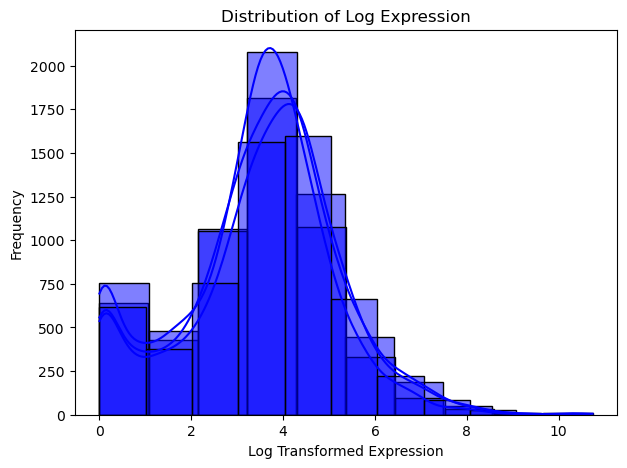

In [11]:
# Plot distribution (histogram + KDE)
plt.figure(figsize=(7, 5))
sns.histplot(data_log.iloc[1], kde=True, bins=10, color='blue', edgecolor='black')
sns.histplot(data_log.iloc[2], kde=True, bins=10, color='blue', edgecolor='black')
sns.histplot(data_log.iloc[3], kde=True, bins=10, color='blue', edgecolor='black')

plt.xlabel("Log Transformed Expression")
plt.ylabel("Frequency")
plt.title(f"Distribution of Log Expression")
plt.show()

In [12]:
### For classification starting with SVM
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(xtrain, ytrain)
y_pred = clf.predict(xtest)


In [13]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(ytest, y_pred))

Accuracy: 0.47619047619047616


In [14]:
y_list = ytest.tolist()
import collections
counter = collections.Counter(y_list)
print(counter)
print(collections.Counter(y_pred))


Counter({1: 50, 0: 30, 2: 25})
Counter({np.int64(1): 105})


### Comparing Multiple Classification Model simulataneously

LR: 0.473268 (0.083264) 18.23633885383606 seconds
LDA: 0.426210 (0.081757) 3.3399529457092285 seconds
KNN: 0.466705 (0.087713) 0.4212486743927002 seconds
DTC: 0.420519 (0.081607) 3.2303338050842285 seconds
NB: 0.455807 (0.064912) 0.4243338108062744 seconds
SVM: 0.483720 (0.087759) 3.0386698246002197 seconds
RF: 0.465428 (0.077027) 3.2648513317108154 seconds
SGD: 0.425939 (0.111078) 1.4195935726165771 seconds


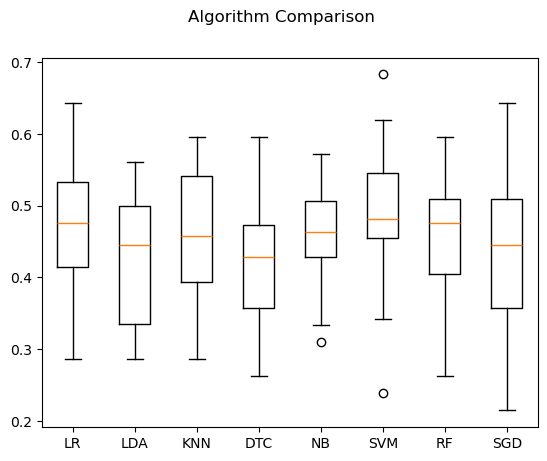

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from datetime import datetime
import time
# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression(max_iter=10000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel='rbf')))
models.append(("RF", RandomForestClassifier(n_estimators = 100)))
# models.append(("GBC", GradientBoostingClassifier(n_estimators=100)))
models.append(("SGD", SGDClassifier(loss="log_loss", penalty="l2")))
# models.append(("LGBM", LGBMClassifier(objective='multiclass', random_state=5)))
# models.append(("XGB",XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start_time = time.time()
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)
    cv_results = cross_val_score(model, xtrain, ytrain, cv=cv, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f) %s seconds" % (name, cv_results.mean(), cv_results.std(), time.time() - start_time)
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Since the machine leanring classification model is not properly able to distinguish the different prostate cancer severity. 
Performing the deep learning network to see if it can learn something from the different layers using Tensorflow

### Deep Learning using TensorFlow


2025-03-04 16:43:57.512186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741135437.600716 2407829 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741135437.628163 2407829 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 16:43:57.842093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'xtrain' is not defined